In [1]:
# Import preliminaries

import requests
import pandas as pd
import config
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
base = 'https://api.stlouisfed.org/fred/series/observations?series_id='

s_list = {
    'Manufacturing': 'CES3000000008',
    'Mining and Logging': 'CES1000000008',
    'Information': 'CES5000000008',
    'Financial Activities': 'CES5500000008',
    'Professional and Business Services': 'CES6000000008',
    'Education and Health Services': 'CES6500000008',
    'Leisure and Hospitality': 'CES7000000008',
    'Other Services': 'CES8000000008',
    'Trade, Transportation, and Utilities': 'CES4000000008',
    'Total Private': 'AHETPI',
    'Construction': 'CES2000000008',
    'CPI All Urban Consumers': 'CPIAUCSL',
    'CPI-Urban Wage Earners and Clerical Workers': 'CWUR0000SA0',
}

dates = '&observation_start=1964-01-01'
key = '&api_key={}'.format(config.fred_key)
ftype = '&file_type=json'

d = {}
p_list = ['CPIAUCSL', 'CWUR0000SA0']
w_list = {k:v for k,v in s_list.iteritems() if v not in p_list}
for k, v in s_list.iteritems():
    url = '{}{}{}{}{}'.format(base, v, dates, key, ftype)
    df = pd.DataFrame(requests.get(url).json()['observations'])
    df = df.set_index(pd.to_datetime(df['date']))
    df = df.rename(columns={'value': v})[v].astype(float)
    d[v] = df
df = pd.DataFrame(d).dropna()
for k, v in w_list.iteritems():
    df[v+'_rw'] = df[v].multiply(df['CWUR0000SA0'][0]).divide(
        df['CWUR0000SA0'])
    df[v+'_rc'] = df[v+'_rw'].pct_change(12).multiply(100)

In [11]:
w_list = {k:v for k,v in s_list.iteritems() if v not in p_list}
for k, v in w_list.iteritems():
    w_list[k] = {'series': v}
    w_list[k]['current_month'] = df.index[-1].strftime('%b %Y')
    w_list[k]['nominal_wage'] = '${:.2f}'.format(df[v][-1])
    w_list[k]['wage_growth_curr'] = str(df[v+'_rc'][-1].round(3))
    ch_val = df.ix['2000-01-01'][v+'_rw']
    w_list[k]['cumulative_change'] = round((df[v+'_rw'][-1] - ch_val)/ch_val * 100,2)
w_list

{'Construction': {'cumulative_change': 7.04,
  'current_month': 'Apr 2017',
  'nominal_wage': '$26.37',
  'series': 'CES2000000008',
  'wage_growth_curr': '0.38'},
 'Education and Health Services': {'cumulative_change': 17.0,
  'current_month': 'Apr 2017',
  'nominal_wage': '$22.96',
  'series': 'CES6500000008',
  'wage_growth_curr': '0.04'},
 'Financial Activities': {'cumulative_change': 24.13,
  'current_month': 'Apr 2017',
  'nominal_wage': '$26.45',
  'series': 'CES5500000008',
  'wage_growth_curr': '-0.82'},
 'Information': {'cumulative_change': 13.73,
  'current_month': 'Apr 2017',
  'nominal_wage': '$30.54',
  'series': 'CES5000000008',
  'wage_growth_curr': '0.202'},
 'Leisure and Hospitality': {'cumulative_change': 13.9,
  'current_month': 'Apr 2017',
  'nominal_wage': '$13.30',
  'series': 'CES7000000008',
  'wage_growth_curr': '1.889'},
 'Manufacturing': {'cumulative_change': 2.09,
  'current_month': 'Apr 2017',
  'nominal_wage': '$20.77',
  'series': 'CES3000000008',
  'wag

In [12]:
w_list = OrderedDict(sorted(w_list.iteritems(), key=lambda x: float(x[1]['cumulative_change'])))

bar_vals = [float(w_list[k]['cumulative_change']) for k in w_list.keys()]

pd.DataFrame(w_list).T[['cumulative_change', 'current_month', 'nominal_wage']].sort_values('cumulative_change', ascending=False).reset_index().to_json('ahe.json', orient='records')

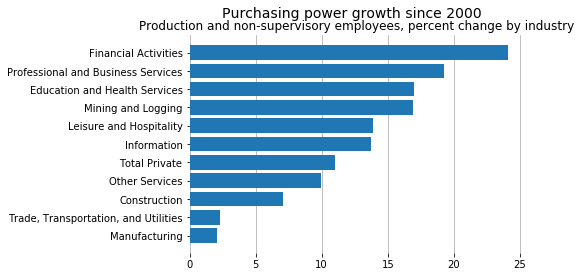

In [13]:
fig, ax = plt.subplots()
ax.xaxis.grid(True)
plt.barh(range(len(w_list)), bar_vals, align='center', zorder=3)
plt.yticks(range(len(w_list)), w_list.keys())
plt.title('Production and non-supervisory employees, percent change by industry')
plt.suptitle('Purchasing power growth since 2000', fontsize=14)
plt.subplots_adjust(top=0.88)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.set_xlim(-50, 490)

plt.show()

# Need to add footnote with source
# Need to sort 
# Need to make to
# Value labels
# Add number of jobs: https://www.bls.gov/web/empsit/ceseeb1a.htm

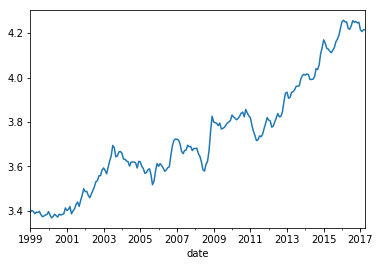

In [14]:
df.iloc[420:]['CES5500000008_rw'].plot()